## Collaborative Filtering

These notebook will compare the performance of _Neural Collaborative Filtering_ **[1]** and _Neural Graph Collaborative Filtering_ **[2]** papers on MovieLens dataset. We would like to see if there is a difference between non-graph based method and a graph-based method on collaborative filtering using MovieLens dataset. We will benefit from [this GitHub repository](https://github.com/talkingwallace/NGCF-pytorch/blob/master/GraphNCF/GCFmodel.py) **[3]** for the implementation of these two models.

**Neural Collaborative Filtering: ** When it comes to model the key factor in collaborative filtering -- the interaction between user and item features, they still resorted to matrix factorization and applied an inner product on the latent features of users and items. By replacing the inner product with a neural architecture that can learn an arbitrary function from data, we present a general framework named NCF, short for Neural network-based Collaborative Filtering.

**Neural Graph Collaborative Filtering: ** In this work, we propose to integrate the user-item interactions --- more specifically the bipartite graph structure --- into the embedding process. We develop a new recommendation framework Neural Graph Collaborative Filtering (NGCF), which exploits the user-item graph structure by propagating embeddings on it. 

***

### Libraries

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import Module
from scipy.sparse import coo_matrix
from scipy.sparse import vstack
from scipy import sparse
import numpy as np
import pandas as pd
from torch.optim import Adam
from torch.nn import MSELoss
from tqdm.notebook import tqdm
import time

np.random.seed(23)

### Data Preprocessing

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class RatingsDataset(Dataset):
    """Ratings Dataset"""

    def __init__(self):
        """
        Args:
            csv_file (string): Path to the csv file with ratings.
        """
        self.csv = pd.read_csv('data/ratings.csv')
        
        self.user_ids = list(self.csv.user_id-1)
        self.movie_ids = list(self.csv.movie_id_ml-1)
        self.ratings = list(self.csv.rating)
        
        self.userNums = np.max(self.user_ids)+1
        self.movieNums = np.max(self.movie_ids)+1

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        return {
            'user': self.user_ids[idx],
            'movie': self.movie_ids[idx], 
            'rating': self.ratings[idx]
        }
    
    def get_user_number(self):
        return self.userNums
    
    def get_movie_number(self):
        return self.movieNums

In [3]:
rt = pd.read_csv('data/ratings.csv')
rt['user_id'] = rt['user_id'] - 1
rt['movie_id_ml'] = rt['movie_id_ml'] - 1

dataset = RatingsDataset()

train_size = int(0.5 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

### Model Implementation - Neural Collaborative Filtering 

In [65]:
class NCF(Module):

    def __init__(self, userNum, itemNum, dim=64, first_layer=128):
        super(NCF, self).__init__()
        
        self.uEmbd = nn.Embedding(userNum, dim)
        self.iEmbd = nn.Embedding(itemNum, dim)
        
        self.fc_layers = nn.Sequential(nn.Linear(dim*2, first_layer),
                                       nn.Dropout(0.),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(first_layer, first_layer//2),
                                       nn.Dropout(0.6),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(first_layer//2, first_layer//4),
                                       nn.Dropout(0.6),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(first_layer//4, first_layer//8),
                                       nn.Dropout(0.6),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(first_layer//8, 1))
        
    def forward(self, userIdx,itemIdx):
        uembd = self.uEmbd(userIdx)
        iembd = self.iEmbd(itemIdx)
        embd = torch.cat([uembd, iembd], dim=1)
        
        prediction = self.fc_layers(embd)
        return prediction.flatten()

### Model Implementation - Neural Graph Collaborative Filtering 

In [6]:
class GNNLayer(Module):

    def __init__(self,inF,outF):

        super(GNNLayer,self).__init__()
        self.inF = inF
        self.outF = outF
        self.linear = torch.nn.Linear(in_features=inF,out_features=outF)
        self.interActTransform = torch.nn.Linear(in_features=inF,out_features=outF)

    def forward(self, laplacianMat,selfLoop,features):
        # for GCF ajdMat is a (N+M) by (N+M) mat
        # laplacianMat L = D^-1(A)D^-1 # 拉普拉斯矩阵
        L1 = laplacianMat + selfLoop
        L2 = laplacianMat#.cuda()
        L1 = L1#.cuda()
        inter_feature = torch.mul(features,features)

        inter_part1 = self.linear(torch.sparse.mm(L1,features))
        inter_part2 = self.interActTransform(torch.sparse.mm(L2,inter_feature))

        return inter_part1+inter_part2
    
class NGCF(Module):

    def __init__(self,userNum,itemNum,rt,embedSize=100,layers=[100,80,50],useCuda=False):

        super(NGCF,self).__init__()
        self.useCuda = useCuda
        self.userNum = userNum
        self.itemNum = itemNum
        self.uEmbd = nn.Embedding(userNum,embedSize)
        self.iEmbd = nn.Embedding(itemNum,embedSize)
        self.GNNlayers = torch.nn.ModuleList()
        self.LaplacianMat = self.buildLaplacianMat(rt) # sparse format
        self.leakyRelu = nn.LeakyReLU()
        self.selfLoop = self.getSparseEye(self.userNum+self.itemNum)

        self.transForm1 = nn.Linear(in_features=layers[-1]*(len(layers))*2,out_features=64)
        self.transForm2 = nn.Linear(in_features=64,out_features=32)
        self.transForm3 = nn.Linear(in_features=32,out_features=1)

        for From,To in zip(layers[:-1],layers[1:]):
            self.GNNlayers.append(GNNLayer(From,To))

    def getSparseEye(self,num):
        i = torch.LongTensor([[k for k in range(0,num)],[j for j in range(0,num)]])
        val = torch.FloatTensor([1]*num)
        return torch.sparse.FloatTensor(i,val)

    def buildLaplacianMat(self,rt):

        rt_item = rt['movie_id_ml'] + self.userNum
        uiMat = coo_matrix((rt['rating'], (rt['user_id'], rt['movie_id_ml'])))

        uiMat_upperPart = coo_matrix((rt['rating'], (rt['user_id'], rt_item)))
        uiMat = uiMat.transpose()
        uiMat.resize((self.itemNum, self.userNum + self.itemNum))

        A = sparse.vstack([uiMat_upperPart,uiMat])
        selfLoop = sparse.eye(self.userNum+self.itemNum)
        sumArr = (A>0).sum(axis=1)
        diag = list(np.array(sumArr.flatten())[0])
        diag = np.power(diag,-0.5)
        D = sparse.diags(diag)
        L = D * A * D
        L = sparse.coo_matrix(L)
        row = L.row
        col = L.col
        i = torch.LongTensor([row,col])
        data = torch.FloatTensor(L.data)
        SparseL = torch.sparse.FloatTensor(i,data)
        return SparseL

    def getFeatureMat(self):
        uidx = torch.LongTensor([i for i in range(self.userNum)])
        iidx = torch.LongTensor([i for i in range(self.itemNum)])
        if self.useCuda == True:
            uidx = uidx.cuda()
            iidx = iidx.cuda()

        userEmbd = self.uEmbd(uidx)
        itemEmbd = self.iEmbd(iidx)
        features = torch.cat([userEmbd,itemEmbd],dim=0)
        return features

    def forward(self,userIdx,itemIdx):

        itemIdx = itemIdx + self.userNum
        userIdx = list(userIdx.cpu().data)
        itemIdx = list(itemIdx.cpu().data)
        # gcf data propagation
        features = self.getFeatureMat()
        finalEmbd = features.clone()
        for gnn in self.GNNlayers:
            features = gnn(self.LaplacianMat,self.selfLoop,features)
            features = nn.ReLU()(features)
            finalEmbd = torch.cat([finalEmbd,features.clone()],dim=1)

        userEmbd = finalEmbd[userIdx]
        itemEmbd = finalEmbd[itemIdx]
        embd = torch.cat([userEmbd,itemEmbd],dim=1)

        embd = nn.ReLU()(self.transForm1(embd))
        embd = self.transForm2(embd)
        embd = self.transForm3(embd)
        prediction = embd.flatten()

        return prediction

### Training

In [7]:
def train(loader, model, optim, loss):
    model.train()
    ls = 0.
    
    for id, batch in enumerate(loader):
        optim.zero_grad()
        prediction = model(batch['user'], batch['movie'])
        loss_ = loss(batch['rating'].float(), prediction)
        loss_.backward()
        optim.step()
        ls += loss_.item()
        
    return ls / len(loader)


def evaluate(loader, model, loss):
    model.eval()
    ls = 0.

    with torch.no_grad():
        for id, batch in enumerate(loader):
            prediction = model(batch['user'], batch['movie'])
            loss_ = loss(batch['rating'].float(), prediction)
            ls += loss_.item()
            
    return ls / len(loader)

In [109]:
BATCH_SIZE = 64
EMBEDDING_DIM = 256
FIRST_LAYER = 2048

In [110]:
trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, drop_last=True)
valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1, drop_last=True)
testLoader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)

In [111]:
model = NCF(dataset.get_user_number(), dataset.get_movie_number(), dim=EMBEDDING_DIM, first_layer=FIRST_LAYER)
#model = NGCF(dataset.get_user_number(), dataset.get_movie_number(), rt)

In [112]:
optim = Adam(model.parameters(), lr=1e-3)
loss = nn.L1Loss()
epoch = 50

train_losses = []
val_losses = []

best_val = np.inf

for i in range(epoch):
    start = time.time()
    TL = train(trainLoader, model, optim, loss)
    VL = evaluate(valLoader, model, loss)
    print("Epoch {} | Train Loss: {:.3f} - Val Loss: {:.3f} - in {:.3f} mins.".format(i+1, TL, VL, (time.time()-start)/60))
    
    if VL < best_val:
        torch.save(model.state_dict(), 'best_ncf_model.pth')
        best_val = VL
    
    train_losses.append(TL)
    val_losses.append(VL)

Epoch 1 | Train Loss: 1.115 - Val Loss: 1.433 - in 1.133 mins.
Epoch 2 | Train Loss: 0.974 - Val Loss: 1.462 - in 1.512 mins.
Epoch 3 | Train Loss: 0.907 - Val Loss: 1.381 - in 1.189 mins.
Epoch 4 | Train Loss: 0.857 - Val Loss: 1.109 - in 1.230 mins.
Epoch 5 | Train Loss: 0.828 - Val Loss: 1.077 - in 1.221 mins.
Epoch 6 | Train Loss: 0.803 - Val Loss: 1.041 - in 1.280 mins.
Epoch 7 | Train Loss: 0.789 - Val Loss: 0.947 - in 1.188 mins.
Epoch 8 | Train Loss: 0.767 - Val Loss: 0.920 - in 1.281 mins.
Epoch 9 | Train Loss: 0.754 - Val Loss: 0.891 - in 1.308 mins.
Epoch 10 | Train Loss: 0.739 - Val Loss: 0.812 - in 1.335 mins.
Epoch 11 | Train Loss: 0.716 - Val Loss: 0.758 - in 1.192 mins.
Epoch 12 | Train Loss: 0.696 - Val Loss: 0.770 - in 1.195 mins.
Epoch 13 | Train Loss: 0.687 - Val Loss: 0.757 - in 1.227 mins.
Epoch 14 | Train Loss: 0.674 - Val Loss: 0.755 - in 1.151 mins.
Epoch 15 | Train Loss: 0.661 - Val Loss: 0.772 - in 1.197 mins.
Epoch 16 | Train Loss: 0.654 - Val Loss: 0.765 - 

### Training Results

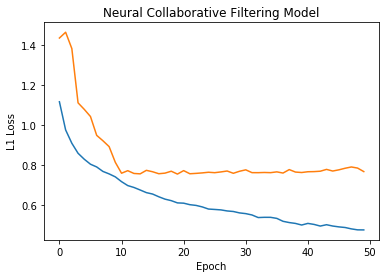

In [116]:
plt.title('Neural Collaborative Filtering Model')
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
_ = plt.ylabel('L1 Loss')
_ = plt.xlabel('Epoch')

***

## References

[1] _He, Xiangnan, et al. "Neural collaborative filtering." Proceedings of the 26th international conference on world wide web. International World Wide Web Conferences Steering Committee, 2017._

[2] _Wang, Xiang, et al. "Neural Graph Collaborative Filtering." arXiv preprint arXiv:1905.08108 (2019)._

[3] _https://github.com/talkingwallace/NGCF-pytorch_